In [4]:
import pandas as pd

# Load the data
data = pd.read_csv('Dr Yahya.csv',low_memory=False)

# Show the first few rows
print(data.head())

# Basic information about the dataset
print(data.info())

   dr                             survey_id     region       district  \
0   1  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   
1   2  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   
2   3  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   
3   4  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   
4   5  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   

          admin0  pcode   n  n_u5  n_died  n_died_u5  ...  \
0  South-Central   1901   4     0       0          0  ...   
1  South-Central   1901   7     2       0          0  ...   
2  South-Central   1901   6     1       0          0  ...   
3  South-Central   1901   6     0       0          0  ...   
4  South-Central   1901  17     1       0          0  ...   

   tot_goat_cereal_smooth_lag4_cat  tot_wage_cereal_smooth_cat  \
0                         <200,000            20,000 to 29,999   
1                         <200,000            20,000 to 29,999

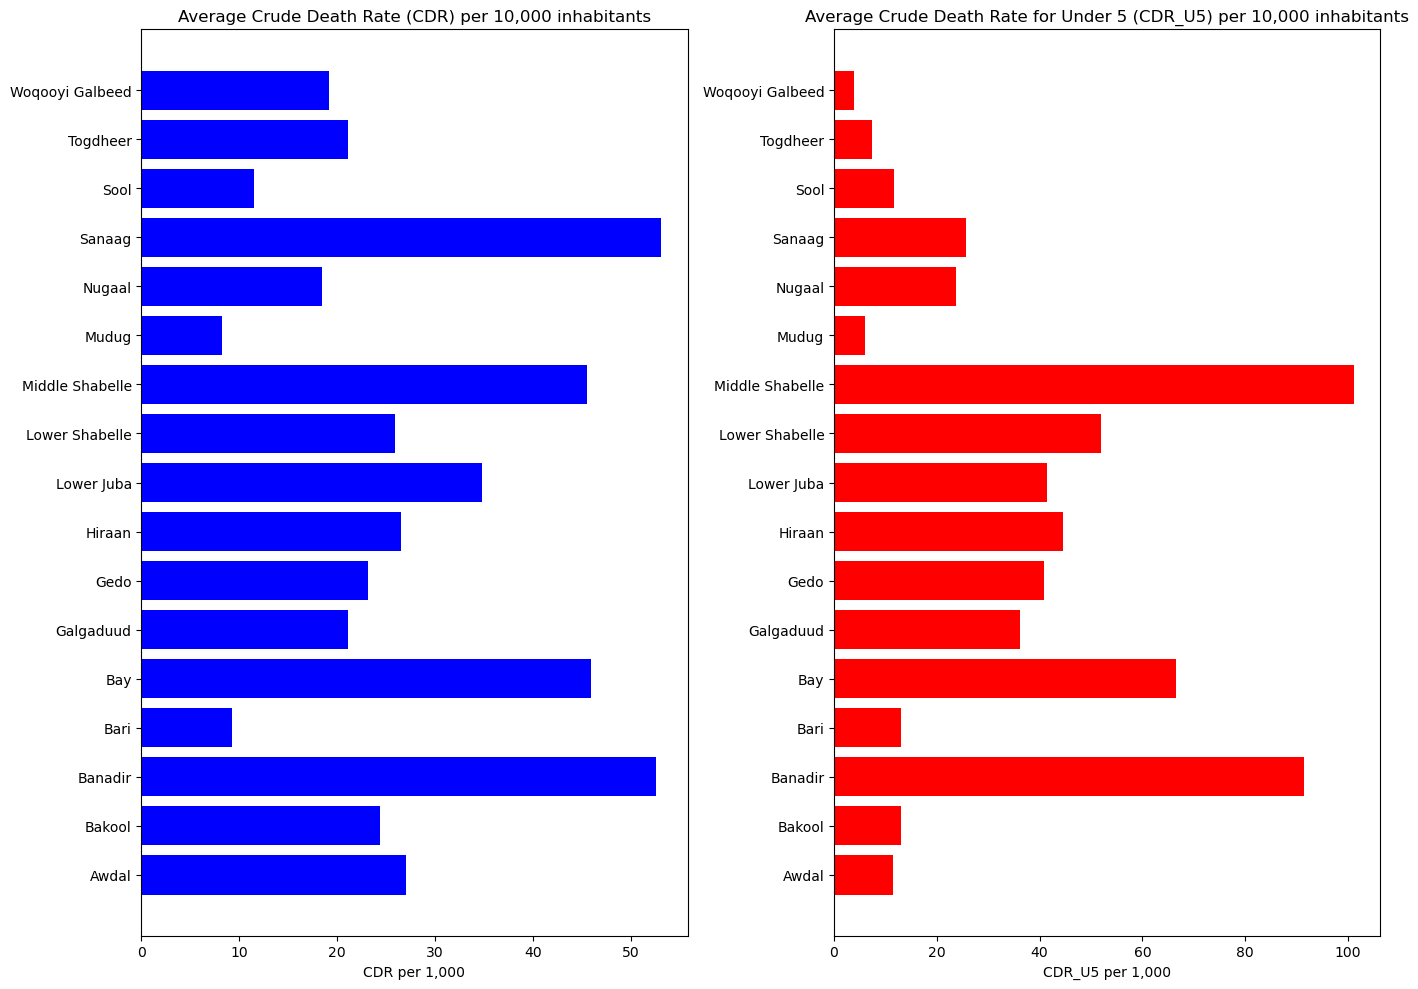

In [5]:
# Calculate CDR and CDR under 5 per region
data['CDR'] = (data['n_died'] / data['n']) * 10000
data['CDR_U5'] = (data['n_died_u5'] / data['n_u5']) * 10000

# Replace infinities or NaN values with 0, which can occur if n or n_u5 is zero
data['CDR'].replace([float('inf'), float('nan')], 0, inplace=True)
data['CDR_U5'].replace([float('inf'), float('nan')], 0, inplace=True)

# Group by region and calculate the average CDR and CDR_U5
regional_cdr = data.groupby('region')[['CDR', 'CDR_U5']].mean().reset_index()

regional_cdr


import matplotlib.pyplot as plt


# Set the plot size
plt.figure(figsize=(14, 10))

# Create a horizontal bar chart for CDR
plt.subplot(1, 2, 1)
plt.barh(regional_cdr['region'], regional_cdr['CDR'], color='blue')
plt.title('Average Crude Death Rate (CDR) per 10,000 inhabitants')
plt.xlabel('CDR per 1,000')

# Create a horizontal bar chart for CDR_U5
plt.subplot(1, 2, 2)
plt.barh(regional_cdr['region'], regional_cdr['CDR_U5'], color='red')
plt.title('Average Crude Death Rate for Under 5 (CDR_U5) per 10,000 inhabitants')
plt.xlabel('CDR_U5 per 1,000')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('CDR and CDR u5 with regions.png')
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Preparing the data for training
# We will predict CDR based on the available features
# For simplicity, let's assume we will use 'rainfall' and the month as features
data['month'] = data['date'].dt.month

# Select features and target
X = data[['rainfall', 'month']]
y = data['CDR']

# Check for missing values in the features
missing_values = X.isna().sum()

# Filling missing values with the mean of each column
X_filled = X.fillna(X.mean())

# Splitting the data into training and testing sets with the filled data
X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(X_filled, y, test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Re-training the models with filled data
lr.fit(X_train_filled, y_train_filled)
dt.fit(X_train_filled, y_train_filled)
rf.fit(X_train_filled, y_train_filled)

# Making predictions
y_pred_lr_filled = lr.predict(X_test_filled)
y_pred_dt_filled = dt.predict(X_test_filled)
y_pred_rf_filled = rf.predict(X_test_filled)

# Calculate the Mean Squared Errors with filled data
mse_lr_filled = mean_squared_error(y_test_filled, y_pred_lr_filled)
mse_dt_filled = mean_squared_error(y_test_filled, y_pred_dt_filled)
mse_rf_filled = mean_squared_error(y_test_filled, y_pred_rf_filled)

# Calculate R² values for the models
r2_lr = r2_score(y_test_filled, y_pred_lr_filled)
r2_dt = r2_score(y_test_filled, y_pred_dt_filled)
r2_rf = r2_score(y_test_filled, y_pred_rf_filled)

# Calculate the variance of the CDR values in the dataset
variance_cdr = y.var()

{
    "missing_values": missing_values,
    "MSE": {
        "Linear Regression": mse_lr_filled,
        "Decision Tree": mse_dt_filled,
        "Random Forest": mse_rf_filled
    },
    "R2": {
        "Linear Regression": r2_lr,
        "Decision Tree": r2_dt,
        "Random Forest": r2_rf
    },
    "Variance of CDR": variance_cdr
}


{'missing_values': rainfall    816
 month         0
 dtype: int64,
 'MSE': {'Linear Regression': 51167.47327254956,
  'Decision Tree': 50892.498862498105,
  'Random Forest': 50889.55719654117},
 'R2': {'Linear Regression': 0.0002355073445076128,
  'Decision Tree': 0.0056082497133558284,
  'Random Forest': 0.005665727110321095},
 'Variance of CDR': 52639.264197601005}

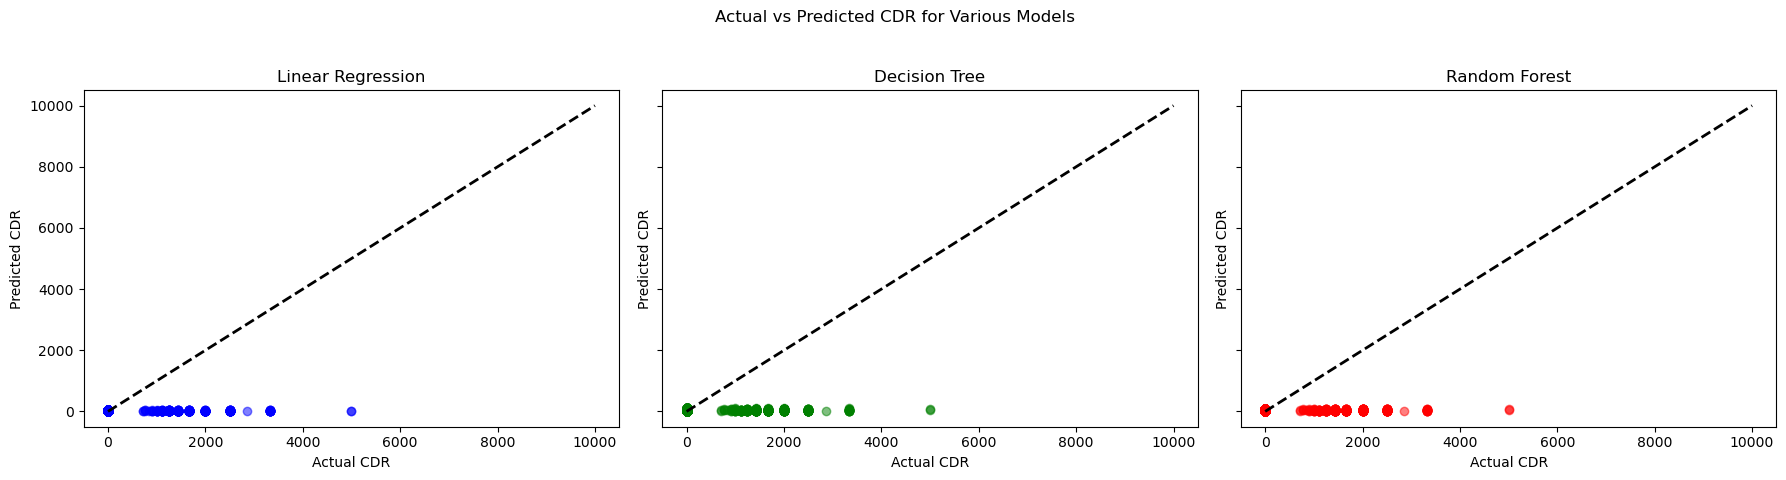

In [23]:
from sklearn.model_selection import cross_val_score

# Performing 5-fold cross-validation for each model and calculating the mean MSE and R² for each
cv_scores_lr_mse = cross_val_score(lr, X_filled, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_dt_mse = cross_val_score(dt, X_filled, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_rf_mse = cross_val_score(rf, X_filled, y, cv=5, scoring='neg_mean_squared_error')

cv_scores_lr_r2 = cross_val_score(lr, X_filled, y, cv=5, scoring='r2')
cv_scores_dt_r2 = cross_val_score(dt, X_filled, y, cv=5, scoring='r2')
cv_scores_rf_r2 = cross_val_score(rf, X_filled, y, cv=5, scoring='r2')

# Calculating the average scores across the folds
cv_results = {
    "Linear Regression": {"MSE": -cv_scores_lr_mse.mean(), "R²": cv_scores_lr_r2.mean()},
    "Decision Tree": {"MSE": -cv_scores_dt_mse.mean(), "R²": cv_scores_dt_r2.mean()},
    "Random Forest": {"MSE": -cv_scores_rf_mse.mean(), "R²": cv_scores_rf_r2.mean()}
}

cv_results



# Generating predictions for each model on the test set for visualization
y_pred_lr = lr.predict(X_test_filled)
y_pred_dt = dt.predict(X_test_filled)
y_pred_rf = rf.predict(X_test_filled)

# Plotting actual vs predicted values for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Linear Regression
axes[0].scatter(y_test_filled, y_pred_lr, alpha=0.5, color='blue')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Actual CDR')
axes[0].set_ylabel('Predicted CDR')

# Decision Tree
axes[1].scatter(y_test_filled, y_pred_dt, alpha=0.5, color='green')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[1].set_title('Decision Tree')
axes[1].set_xlabel('Actual CDR')
axes[1].set_ylabel('Predicted CDR')

# Random Forest
axes[2].scatter(y_test_filled, y_pred_rf, alpha=0.5, color='red')
axes[2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[2].set_title('Random Forest')
axes[2].set_xlabel('Actual CDR')
axes[2].set_ylabel('Predicted CDR')

fig.suptitle('Actual vs Predicted CDR for Various Models')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('model_predictions.png')
plt.show()


In [9]:



# Determine the last month in the dataset
last_date = data['date'].max()

# Calculate the months for the next three months
import calendar
from dateutil.relativedelta import relativedelta

next_month = last_date + relativedelta(months=1)
second_month = last_date + relativedelta(months=2)
third_month = last_date + relativedelta(months=3)

# Assuming average rainfall for simplicity
# Let's use the mean rainfall for each corresponding month from the past data as an assumption for future rainfall
rainfall_next_month = data[data['date'].dt.month == next_month.month]['rainfall'].mean()
rainfall_second_month = data[data['date'].dt.month == second_month.month]['rainfall'].mean()
rainfall_third_month = data[data['date'].dt.month == third_month.month]['rainfall'].mean()

# Prepare the feature set for prediction
future_months = pd.DataFrame({
    'rainfall': [rainfall_next_month, rainfall_second_month, rainfall_third_month],
    'month': [next_month.month, second_month.month, third_month.month]
})

future_months




,rainfall,month
0,37.193784,7
1,NaN,8
2,19.397852,9


In [14]:
# Preparing the target for CDR_U5 predictions
y_u5 = data['CDR_U5']

# Splitting the data for CDR_U5
X_train_u5, X_test_u5, y_train_u5, y_test_u5 = train_test_split(X_filled, y_u5, test_size=0.2, random_state=42)

# Initialize a new Random Forest model for CDR_U5
rf_u5 = RandomForestRegressor(random_state=42)

# Training the model for CDR_U5
rf_u5.fit(X_train_u5, y_train_u5)

# Making predictions for the next three months using the trained Random Forest model for CDR_U5
predictions_u5_next_three_months = rf_u5.predict(future_months)

# Add the predicted CDR_U5 to the DataFrame
predicted_cdr['Predicted CDR_U5'] = predictions_u5_next_three_months

predicted_cdr


# Fill the missing rainfall value for August by averaging July and September
future_months.loc[1, 'rainfall'] = (future_months.loc[0, 'rainfall'] + future_months.loc[2, 'rainfall']) / 2

# Making predictions for the next three months using the trained Random Forest model
predictions_next_three_months = rf.predict(future_months)

# Create a DataFrame to display the months with their predictions
predicted_cdr = pd.DataFrame({
    'Month': ['July', 'August', 'September'],
    'Predicted CDR': predictions_next_three_months
    
})
predicted_cdr['Predicted CDR_U5'] = predictions_u5_next_three_months
predicted_cdr


,Month,Predicted CDR,Predicted CDR_U5
0,July,21.751670,34.872197
1,August,44.626728,80.070208
2,September,39.644240,77.046111


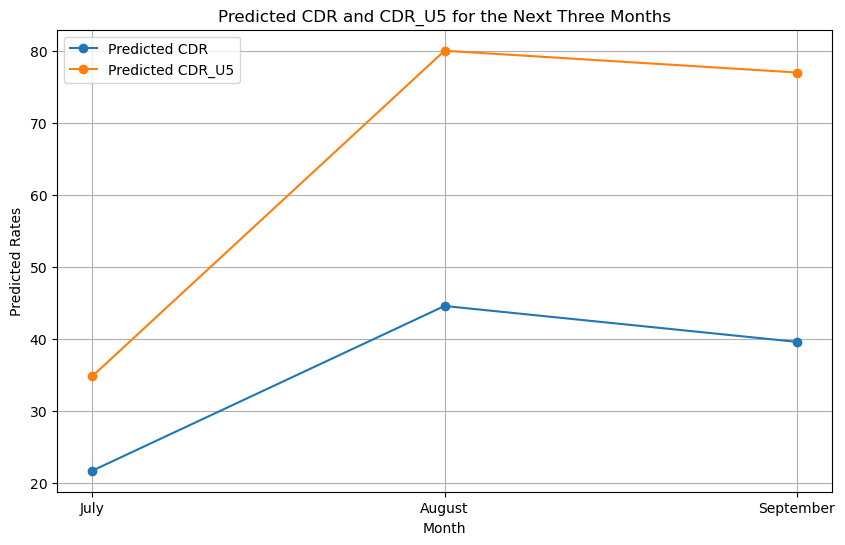

In [26]:
# Plotting the predictions
plt.figure(figsize=(10, 6))
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR'], label='Predicted CDR', marker='o')
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_U5'], label='Predicted CDR_U5', marker='o')
plt.title('Predicted CDR and CDR_U5 for the Next Three Months')
plt.xlabel('Month')
plt.ylabel('Predicted Rates')
plt.grid(True)
plt.legend()
plt.savefig('futere_prediction.png')
plt.show()

/tmp/ipykernel_5144/1930053229.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

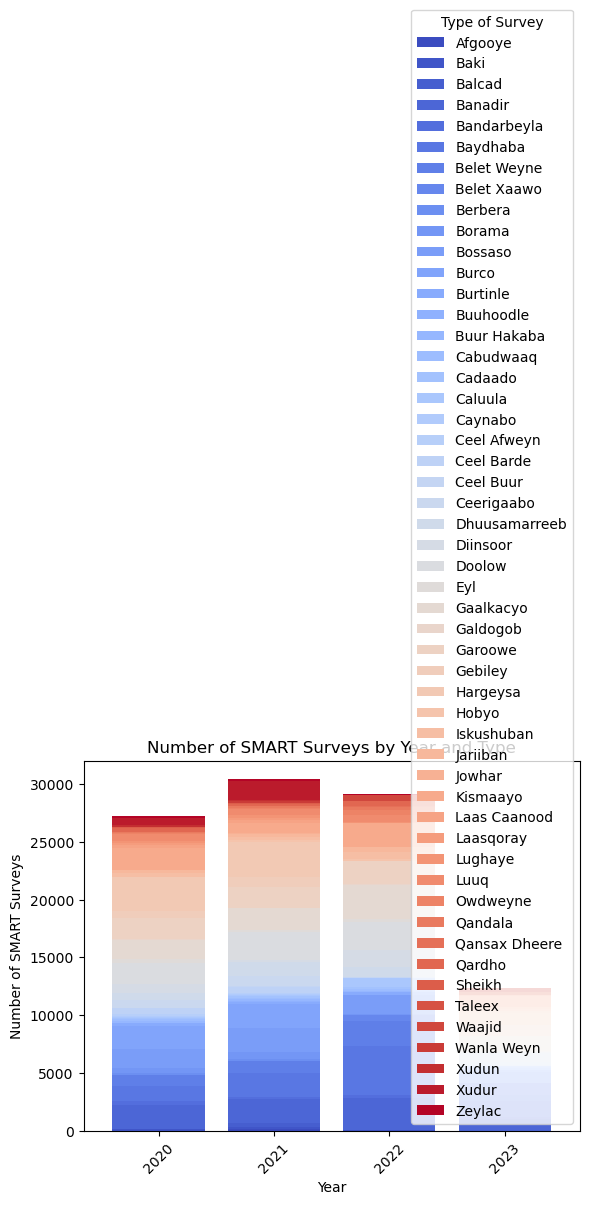

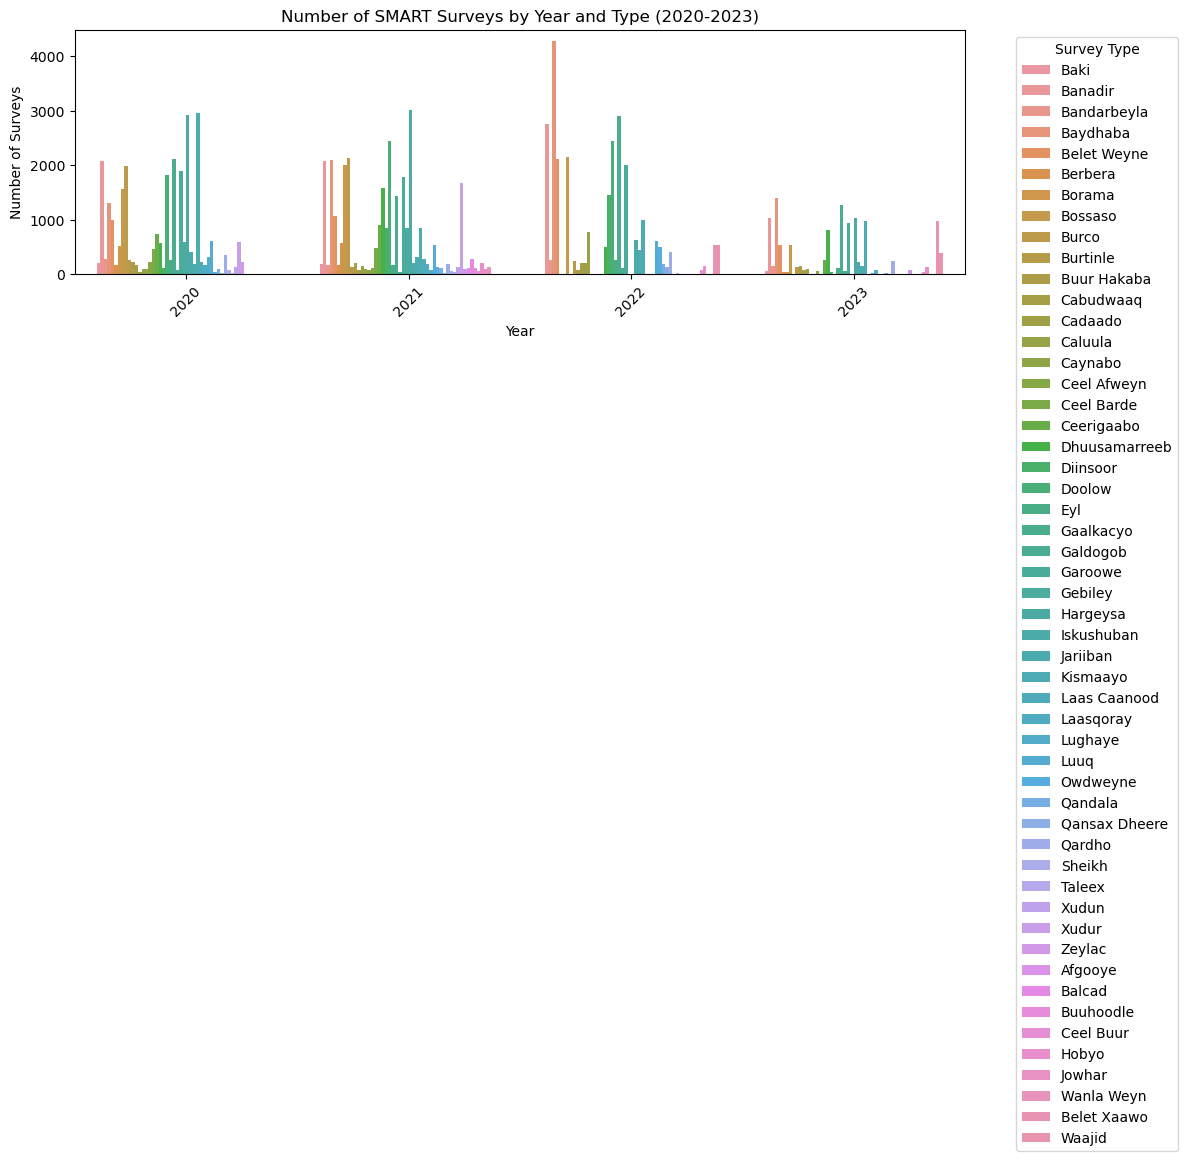

In [37]:

filtered_data = data[data['parsed_year'].isin(['2020', '2021', '2022', '2023'])]

# Assuming survey types are in a column named 'survey_type', if not we need to extract that information as well.
# For now, we will create a dummy 'survey_type' column to proceed with the plotting.
filtered_data['survey_type'] = filtered_data['district']  # Replace with the correct logic to determine survey type

# Aggregate filtered data for plotting
filtered_survey_count = filtered_data.groupby(['parsed_year', 'survey_type']).size().reset_index(name='counts')

# Plotting the filtered data
plt.figure(figsize=(12, 8))
sns.barplot(x='parsed_year', y='counts', hue='survey_type', data=filtered_survey_count)
plt.title('Number of SMART Surveys by Year and Type (2020-2023)')
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Surveys')
plt.legend(title='Survey Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save and display the plot
plt.savefig('filtered_smart_surveys_by_year.png')
plt.show()